In [2]:
import os
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
from zipfile import ZipFile
import PIL
from PIL import Image
import math

import warnings
import tensorflow as tf

In [90]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [6]:
data_dir_cells="../fp_data/finalproj_data/cleared_cells/"
data_dir_space="../fp_data/finalproj_data/cleared_space/"
pic_paths=[];


In [39]:
pic_paths.remove('../fp_data/finalproj_data/cleared_space/17.9.jpg')

In [41]:
one_im=Image.open(pic_paths[3])

In [43]:
w,h=one_im.size

In [45]:
print(w,h)

587 440


In [7]:
for filename in os.listdir(data_dir_cells):
    pic_paths.append(data_dir_cells+filename)
for filename in os.listdir(data_dir_space):
    pic_paths.append(data_dir_space+filename)


In [11]:
def get_batch(image_files, x,y,width, height):
    
    data_batch = np.array([cropresize_array(img, x, y, width, height) for img in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

In [46]:
def cropresize_array(img, x, y, width, height):
        img=Image.open(img)
        imw, imh=img.size;
        if(imw>=imh):
            cropped_img=img.crop((0,0,imh,imh))
        else:
            cropped_img=img.crop((0,0,imw, imw))
        resized_img=cropped_img.resize([28,28], PIL.Image.LANCZOS)
        
        return np.array(resized_img.convert("RGB"))


In [13]:
class Dataset(object):
    def __init__(self, dataset_name, data_files):
        
        IMAGE_WIDTH = 28
        IMAGE_HEIGHT = 28
        image_channels=3

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels
        self.image_mode="RGB"

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255
        start_x=10;
        start_y=5;
        crop_width=40;
        crop_height=crop_width;



        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                start_x,
                start_y,
                crop_width,
                crop_height)

            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

In [14]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return (real_input, z_input, learning_rate)


In [15]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input 28x28x3
        
        c1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d1 = tf.nn.dropout(c1, keep_prob=keep_prob)
        reul1 = tf.maximum(alpha*d1, d1)
        # 14X14x64
        
        c2 = tf.layers.conv2d(c1, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d2 = tf.nn.dropout(c2, keep_prob=keep_prob)
        bn2 = tf.layers.batch_normalization(d2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        # 7x7x128
        
        c3 = tf.layers.conv2d(c2, filters=256, kernel_size=(5,5), strides=(2,2), padding='SAME', 
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        d3 = tf.nn.dropout(c3, keep_prob=keep_prob)
        bn3 = tf.layers.batch_normalization(d3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.8):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # Project input vector
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape to start convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 2x2x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=(5,5), strides=(2,2), padding='VALID',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.nn.dropout(x2, keep_prob=keep_prob)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=(5,5), strides=(2,2), padding='SAME',
                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=(5,5), strides=(2,2), padding='SAME',
                    kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # 28x28x3
        out = tf.tanh(logits)
        return out

In [17]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, keep_prob=0.8):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_faked = generator(input_z, out_channel_dim, is_train=True, alpha=alpha, keep_prob=keep_prob)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha, keep_prob=keep_prob)
    d_model_fake, d_logits_fake = discriminator(g_faked, reuse=True, alpha=alpha, keep_prob=keep_prob)
    
    # Add smoothing to reduce labels
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=(tf.ones_like(d_model_real) * 0.9)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    
    d_loss = d_loss_fake + d_loss_real
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=(tf.ones_like(d_model_fake))
        )
    )
    
    return d_loss, g_loss

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

In [19]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    alpha = 0.12
    keep_prob = 0.75
    n_samples, width, height, channels = data_shape
    input_real, input_z, learning_rate_tf = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels, alpha=alpha, keep_prob=keep_prob)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_tf, beta1)
    
    current_step = 0
    print_loss_every = 10
    show_image_every = 50
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                current_step +=1
                
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_tf:learning_rate})
                
                if current_step % print_loss_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if current_step % show_image_every == 0:
                    n_images = 16
                    single_img=show_generator_output(sess, n_images, input_z, channels, data_image_mode)
                    pyplot.imshow(single_img);
                    pyplot.show()
                

In [20]:
def images_square_grid(images, mode="RGB"):

    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    new_single=images[np.random.randint(0,len(images)-1)]
    
    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im, new_single;

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid, image_single = images_square_grid(samples, image_mode)
    f1=pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
    return image_single

Epoch 0/40... Discriminator Loss: 2.1320... Generator Loss: 0.2852
Epoch 0/40... Discriminator Loss: 0.4405... Generator Loss: 2.5343
Epoch 0/40... Discriminator Loss: 1.6164... Generator Loss: 0.4244
Epoch 1/40... Discriminator Loss: 1.8450... Generator Loss: 1.6939
Epoch 1/40... Discriminator Loss: 2.4842... Generator Loss: 4.0108


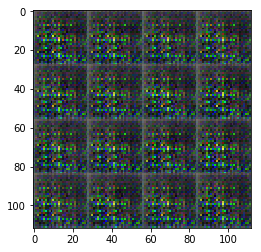

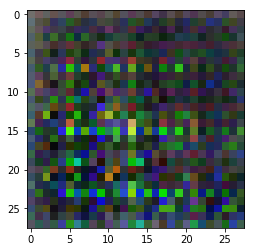

Epoch 1/40... Discriminator Loss: 1.0807... Generator Loss: 1.9545
Epoch 2/40... Discriminator Loss: 1.2092... Generator Loss: 1.2893
Epoch 2/40... Discriminator Loss: 1.1426... Generator Loss: 1.2600
Epoch 2/40... Discriminator Loss: 0.9374... Generator Loss: 1.4859
Epoch 3/40... Discriminator Loss: 1.0686... Generator Loss: 1.4030


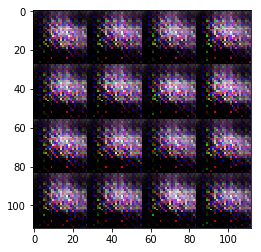

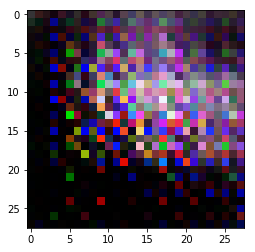

Epoch 3/40... Discriminator Loss: 1.2930... Generator Loss: 0.9552
Epoch 3/40... Discriminator Loss: 0.8835... Generator Loss: 1.8629
Epoch 4/40... Discriminator Loss: 0.6704... Generator Loss: 2.0779
Epoch 4/40... Discriminator Loss: 0.4981... Generator Loss: 2.7644
Epoch 4/40... Discriminator Loss: 3.2130... Generator Loss: 5.3684


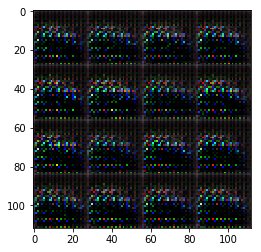

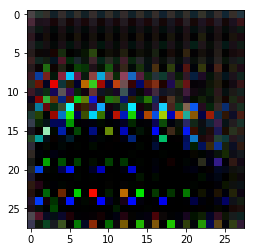

Epoch 5/40... Discriminator Loss: 0.6278... Generator Loss: 2.4925
Epoch 5/40... Discriminator Loss: 0.5236... Generator Loss: 2.0483
Epoch 5/40... Discriminator Loss: 0.4676... Generator Loss: 2.5301
Epoch 6/40... Discriminator Loss: 0.4415... Generator Loss: 5.9639
Epoch 6/40... Discriminator Loss: 0.5678... Generator Loss: 2.7011


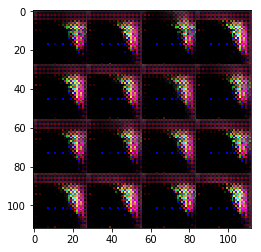

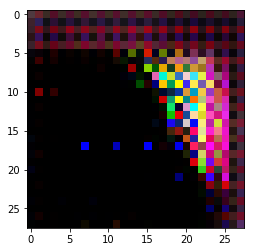

Epoch 6/40... Discriminator Loss: 0.9012... Generator Loss: 1.1105
Epoch 7/40... Discriminator Loss: 0.4703... Generator Loss: 3.8357
Epoch 7/40... Discriminator Loss: 0.3840... Generator Loss: 3.8429
Epoch 7/40... Discriminator Loss: 0.7784... Generator Loss: 2.3594
Epoch 8/40... Discriminator Loss: 0.6643... Generator Loss: 2.0787


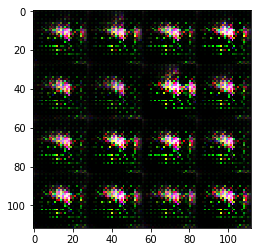

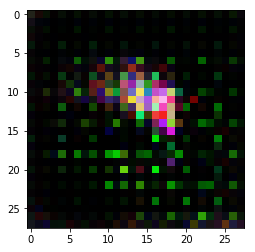

Epoch 8/40... Discriminator Loss: 0.5513... Generator Loss: 2.3331
Epoch 8/40... Discriminator Loss: 0.5578... Generator Loss: 3.1403
Epoch 9/40... Discriminator Loss: 0.4869... Generator Loss: 3.2130
Epoch 9/40... Discriminator Loss: 0.4725... Generator Loss: 2.8144
Epoch 9/40... Discriminator Loss: 0.7511... Generator Loss: 1.6878


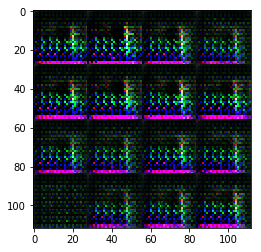

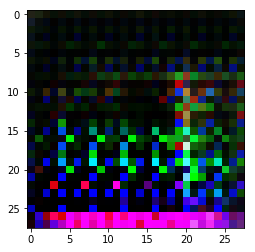

Epoch 9/40... Discriminator Loss: 0.5958... Generator Loss: 2.5786
Epoch 10/40... Discriminator Loss: 0.4550... Generator Loss: 3.6641
Epoch 10/40... Discriminator Loss: 1.1469... Generator Loss: 2.5685
Epoch 10/40... Discriminator Loss: 1.4820... Generator Loss: 0.8857
Epoch 11/40... Discriminator Loss: 0.7329... Generator Loss: 2.2526


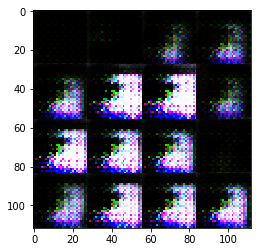

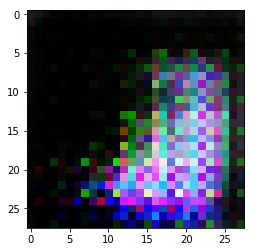

Epoch 11/40... Discriminator Loss: 1.0367... Generator Loss: 1.1259
Epoch 11/40... Discriminator Loss: 0.8044... Generator Loss: 1.8291
Epoch 12/40... Discriminator Loss: 0.8777... Generator Loss: 2.1948
Epoch 12/40... Discriminator Loss: 0.8908... Generator Loss: 1.3815
Epoch 12/40... Discriminator Loss: 0.6109... Generator Loss: 1.9317


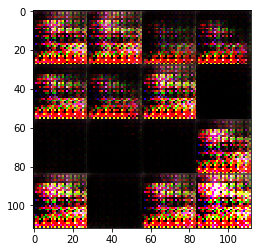

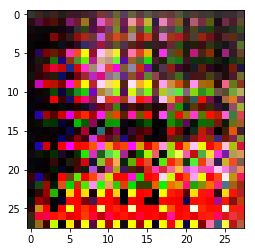

Epoch 13/40... Discriminator Loss: 0.9049... Generator Loss: 1.4458
Epoch 13/40... Discriminator Loss: 0.7394... Generator Loss: 2.0094
Epoch 13/40... Discriminator Loss: 0.7680... Generator Loss: 1.7104
Epoch 14/40... Discriminator Loss: 1.3703... Generator Loss: 0.9036
Epoch 14/40... Discriminator Loss: 1.1130... Generator Loss: 1.0705


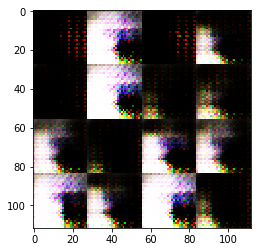

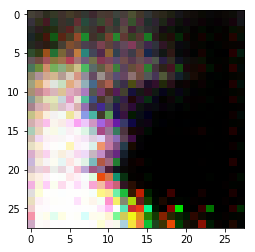

Epoch 14/40... Discriminator Loss: 0.8558... Generator Loss: 1.7414
Epoch 15/40... Discriminator Loss: 0.6833... Generator Loss: 1.9454
Epoch 15/40... Discriminator Loss: 1.1782... Generator Loss: 0.9793
Epoch 15/40... Discriminator Loss: 1.3736... Generator Loss: 0.9101
Epoch 16/40... Discriminator Loss: 0.8962... Generator Loss: 1.7419


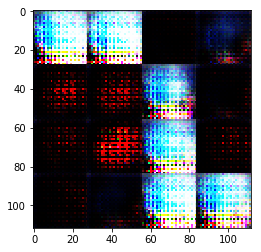

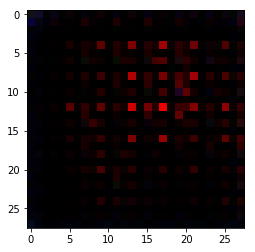

Epoch 16/40... Discriminator Loss: 0.7927... Generator Loss: 1.6225
Epoch 16/40... Discriminator Loss: 0.8051... Generator Loss: 1.5284
Epoch 17/40... Discriminator Loss: 0.7753... Generator Loss: 1.4012
Epoch 17/40... Discriminator Loss: 0.5602... Generator Loss: 2.1360
Epoch 17/40... Discriminator Loss: 0.5557... Generator Loss: 2.0708


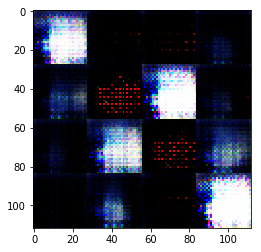

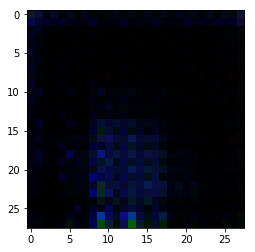

Epoch 18/40... Discriminator Loss: 1.0611... Generator Loss: 1.4100
Epoch 18/40... Discriminator Loss: 1.0522... Generator Loss: 1.1896
Epoch 18/40... Discriminator Loss: 0.8879... Generator Loss: 1.3208
Epoch 19/40... Discriminator Loss: 1.4130... Generator Loss: 1.0846
Epoch 19/40... Discriminator Loss: 0.8065... Generator Loss: 1.8198


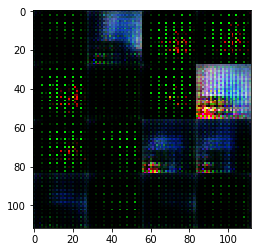

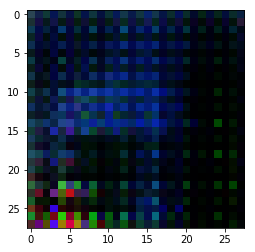

Epoch 19/40... Discriminator Loss: 1.1881... Generator Loss: 1.2289
Epoch 19/40... Discriminator Loss: 0.9809... Generator Loss: 1.5271
Epoch 20/40... Discriminator Loss: 0.9517... Generator Loss: 1.2279
Epoch 20/40... Discriminator Loss: 0.8924... Generator Loss: 1.3782
Epoch 20/40... Discriminator Loss: 0.9215... Generator Loss: 1.4602


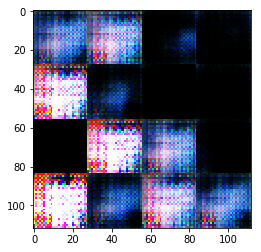

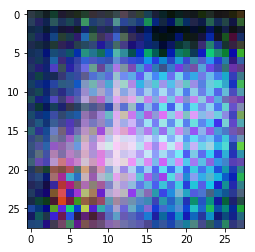

Epoch 21/40... Discriminator Loss: 0.9310... Generator Loss: 1.2098
Epoch 21/40... Discriminator Loss: 1.3764... Generator Loss: 1.6101
Epoch 21/40... Discriminator Loss: 1.1794... Generator Loss: 1.1877
Epoch 22/40... Discriminator Loss: 1.3757... Generator Loss: 0.9940
Epoch 22/40... Discriminator Loss: 1.8307... Generator Loss: 0.3249


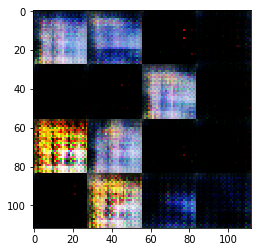

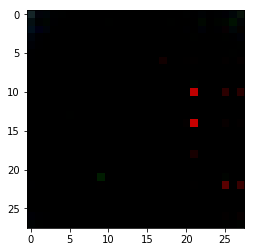

Epoch 22/40... Discriminator Loss: 1.0513... Generator Loss: 1.1460
Epoch 23/40... Discriminator Loss: 1.1511... Generator Loss: 2.0475


KeyboardInterrupt: 

In [47]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005

beta1 = 0.7

epochs = 40

space_cell_data = Dataset('cellspace', pic_paths)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, space_cell_data.get_batches,
          space_cell_data.shape, space_cell_data.image_mode)